**Import Libraries**

In [73]:
import os
import math
import time
import warnings
from dataclasses import dataclass
from typing import Tuple, Optional, List, Dict, Set

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import qr, solve_triangular
from scipy.stats import ttest_rel

from sklearn.datasets import make_regression, make_classification, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

try:
    from joblib import Parallel, delayed
    JOBLIB_OK = True
except Exception:
    JOBLIB_OK = False
    def Parallel(n_jobs=-1, prefer="threads"):
        def wrapper(gen):
            return [func(*args, **kwargs) for func, args, kwargs in gen]
        return wrapper

    def delayed(func):
        def wrapper(*args, **kwargs):
            return func, args, kwargs
        return wrapper

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

**Utilities**

In [74]:
def set_seed(seed: int):
    np.random.seed(seed)


def mean_std(x):
    a = np.asarray(x, dtype=float)
    return float(a.mean()), float(a.std())


def save_csv(path: str, header: List[str], rows: List[List[float]]):
    try:
        import csv
        with open(path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(header)
            w.writerows(rows)
    except Exception as e:
        print(f"[WARN] CSV save failed for {path}: {e}")


def paired_test_report(name: str, a: List[float], b: List[float]) -> Tuple[float, float, float]:
    a = np.asarray(a, float); b = np.asarray(b, float)
    delta = a - b
    t, p = ttest_rel(a, b)
    md = float(delta.mean())
    print(f"  {name}: meanΔ={md:+.4f}, t={t:.2f}, p={p:.4g}")
    return md, float(t), float(p)


**Target-Aware ARS(Adaptive Residual Sampling) QRCP**

In [75]:
class TAAQ:
    def __init__(
        self,
        k: int,
        k1_ratio: float = 0.25,
        epsilon: float = 1e-6,
        min_energy_threshold: float = 1e-12,
        diversity_tau: float = 0.2,
        verbose: bool = False,
    ):
        self.k = int(k)
        self.k1 = max(0, int(k * k1_ratio))
        self.epsilon = float(epsilon)
        self.min_energy_threshold = float(min_energy_threshold)
        self.diversity_tau = float(diversity_tau)
        self.verbose = verbose
        self.selected_indices_: Optional[np.ndarray] = None
        self.phase_info_: Dict = {}
        
        if self.k1 > self.k:
            self.k1 = self.k

    def fit(self, M: np.ndarray, y: Optional[np.ndarray] = None,
            ablate_gate: bool = False, ablate_tprs: bool = False, 
            ablate_prune: bool = False) -> "TAAQ": 
        
        m, n = M.shape
        if self.k > n:
            raise ValueError(f"k={self.k} > n={n}")
            
        M_std, y_std, self.col_mean_, self.col_std_ = self._preprocess(M, y)

        # Phase I
        if ablate_gate or self.k1 == 0:
            S1, Q1 = [], np.zeros((m, 0))
        else:
            S1, Q1 = self._phase1_qrcp_gate(M_std, self.k1)
        self.phase_info_["S1"] = S1

        # Phase II
        target_size = self.k 
        
        if len(S1) >= target_size:
            S_final = S1[:target_size]
        elif ablate_tprs:
            S_final = self._phase2_fill_by_energy(M_std, S1, Q1, target_size)
        else:
            if y_std is not None:
                S_final = self._phase2_tprs_supervised(M_std, y_std, S1, Q1, target_size)
            else:
                S_final = self._phase2_tprs_unsupervised(M_std, S1, Q1, target_size)
        
        self.phase_info_["S_final"] = S_final
        self.selected_indices_ = np.array(sorted(S_final))
        return self

    def transform(self, M: np.ndarray) -> np.ndarray:
        if self.selected_indices_ is None:
            raise ValueError("fit() first.")
        return M[:, self.selected_indices_]

    def fit_transform(self, M: np.ndarray, y: Optional[np.ndarray] = None, **kwargs) -> np.ndarray:
        self.fit(M, y, **kwargs)
        return self.transform(M)

    def _preprocess(self, M: np.ndarray, y: Optional[np.ndarray]):
        m, n = M.shape
        col_mean = M.mean(axis=0)
        col_std = M.std(axis=0) + 1e-10
        M_std = (M - col_mean) / col_std
        if y is not None:
            y_c = y - y.mean()
            yn = np.linalg.norm(y_c)
            y_std = (y_c * np.sqrt(m) / yn) if yn > 1e-10 else y_c
        else:
            y_std = None
        return M_std, y_std, col_mean, col_std

    def _phase1_qrcp_gate(self, M: np.ndarray, k1: int) -> Tuple[List[int], np.ndarray]:
        m, n = M.shape
        M_work = M.copy()
        S1 = []
        col_norms_sq = np.sum(M_work ** 2, axis=0)
        pivots = np.arange(n)
        
        k1_actual = min(k1, n, m)
        
        for t in range(k1_actual):
            remaining_idx = np.arange(t, n)
            if remaining_idx.size == 0: break
                
            pivot_loc = t + int(np.argmax(col_norms_sq[t:]))
            pivot_val = pivots[pivot_loc]
            S1.append(pivot_val)

            if pivot_loc != t:
                M_work[:, [t, pivot_loc]] = M_work[:, [pivot_loc, t]]
                col_norms_sq[[t, pivot_loc]] = col_norms_sq[[pivot_loc, t]]
                pivots[[t, pivot_loc]] = pivots[[pivot_loc, t]]

            if t == k1_actual - 1: break
                
            v = M_work[t:, t].copy()
            v_norm = np.linalg.norm(v) + 1e-12
            v[0] += (1.0 if v[0] >= 0 else -1.0) * v_norm
            v /= (np.linalg.norm(v) + 1e-12)
            
            M_work[t:, t:] -= 2.0 * np.outer(v, v @ M_work[t:, t:])
            col_norms_sq[t + 1:] = np.sum(M_work[t + 1:, t + 1:] ** 2, axis=0)

        C1 = M[:, S1] if S1 else np.zeros((m, 0))
        Q1, _ = qr(C1, mode="economic") if S1 else (np.zeros((m, 0)), np.zeros((0, 0)))
        return S1, Q1

    def _phase2_fill_by_energy(self, M: np.ndarray, S1: List[int], Q1: np.ndarray, target_size: int) -> List[int]:
        m, n = M.shape
        gated = M - Q1 @ (Q1.T @ M) if Q1.shape[1] > 0 else M
        b = np.sum(gated ** 2, axis=0)
        order = list(np.argsort(-b))
        S = list(S1)
        S_set = set(S)
        for j in order:
            if len(S) >= target_size:
                break
            if j not in S_set and b[j] >= self.min_energy_threshold:
                S.append(j)
                S_set.add(j)
        return S

    def _compute_diversity_penalty(self, M_res: np.ndarray, S_res: List[int], S_full: List[int]) -> np.ndarray:
        if self.diversity_tau <= 0 or len(S_full) == 0 or len(S_res) == 0:
            return np.ones(len(S_res), dtype=float)
        
        Xs = M_res[:, S_full] 
        Xs_norm = np.linalg.norm(Xs, axis=0) + 1e-12
        Xs_n = Xs / Xs_norm
        
        Xr = M_res[:, S_res]
        Xr_n = Xr / (np.linalg.norm(Xr, axis=0) + 1e-12)
        
        sims = np.abs(Xs_n.T @ Xr_n).max(axis=0) 
        penalties = np.clip(1.0 - self.diversity_tau * sims, 0.1, 1.0)
        return penalties

    def _phase2_tprs_supervised(self, M: np.ndarray, y: np.ndarray, S1: List[int], Q1: np.ndarray, target_size: int) -> List[int]:
        m, n = M.shape
        if target_size <= len(S1):
            return S1.copy()
        
        r_y = y - Q1 @ (Q1.T @ y) if Q1.shape[1] > 0 else y.copy()
        gated = M - Q1 @ (Q1.T @ M) if Q1.shape[1] > 0 else M
        b = np.sum(gated ** 2, axis=0)

        S = S1.copy()
        eligible_mask = (b >= self.min_energy_threshold)
        if len(S) > 0:
            eligible_mask[S] = False

        while len(S) < target_size:
            remaining_idx = np.where(eligible_mask)[0]
            if remaining_idx.size == 0:
                break
            
            s = gated[:, remaining_idx].T @ r_y
            a = (s * s) / (b[remaining_idx] + self.epsilon)
            
            a *= self._compute_diversity_penalty(gated, remaining_idx, S)
            
            j = int(remaining_idx[int(np.argmax(a))])
            S.append(j)
            eligible_mask[j] = False

            xj_perp = gated[:, j]
            nx = np.linalg.norm(xj_perp)
            if nx > 1e-10:
                u = xj_perp / nx
                r_y = r_y - (u @ r_y) * u
        return S

    def _phase2_tprs_unsupervised(self, M: np.ndarray, S1: List[int], Q1: np.ndarray, target_size: int) -> List[int]:
        m, n = M.shape
        gated = M - Q1 @ (Q1.T @ M) if Q1.shape[1] > 0 else M
        b = np.sum(gated ** 2, axis=0)
        S = S1.copy()
        eligible_mask = (b >= self.min_energy_threshold)
        if len(S) > 0:
            eligible_mask[S] = False
            
        while len(S) < target_size:
            remaining_idx = np.where(eligible_mask)[0]
            if remaining_idx.size == 0:
                break
            
            a = b[remaining_idx].copy()
            a *= self._compute_diversity_penalty(gated, remaining_idx, S)

            j = int(remaining_idx[int(np.argmax(a))])
            S.append(j)
            eligible_mask[j] = False
        return S

**Baseline & Evaluation Helpers**

In [76]:
def ridge_on_selected(Xtr, ytr, Xte, yte, idx):
    if len(idx) == 0:
        return -np.inf
    m = Ridge(alpha=1.0, random_state=42)
    m.fit(Xtr[:, idx], ytr)
    return r2_score(yte, m.predict(Xte[:, idx]))


def topk_by_coef(estimator, Xtr, ytr, k):
    estimator.fit(Xtr, ytr)
    coef = getattr(estimator, "coef_", None)
    if coef is None:
        return np.array([], dtype=int)
    coef = np.abs(coef)
    if coef.ndim > 1:
        coef = coef.mean(axis=0)
    order = np.argsort(-coef)
    return order[:k]


def svd_quality(C: np.ndarray) -> Tuple[float, float]:
    try:
        u, s, vt = np.linalg.svd(C, full_matrices=False)
        if s.size == 0:
            return np.inf, -np.inf
        cond = float(s[0] / (s[-1] + 1e-12))
        logdet = 2.0 * float(np.sum(np.log(np.abs(s) + 1e-12)))
    except np.linalg.LinAlgError:
        cond, logdet = np.inf, -np.inf
    return cond, logdet

**Domain-specific Hyper-param Adapters**

In [77]:
# Feature selection: LOW k1_ratio to prioritize TPRS-Supervised
FS_K_CFG = {
    20: dict(k1_ratio=0.1, diversity_tau=0.1),
    50: dict(k1_ratio=0.1, diversity_tau=0.1),
    100:dict(k1_ratio=0.1, diversity_tau=0.2),
}

# Coreset: HIGH k1_ratio and HIGH diversity (ARS-QRCP)
CO_DIVERSE = dict(k1_ratio=0.4, diversity_tau=0.75)

**Experiment 1: Feature Selection (Regression)**

In [78]:
def exp_feature_selection(seeds=(0,1,2), k_values=(20,50,100),
                          n_samples=500, n_features=1000, n_informative=50,
                          grfs_kwargs=None):
    print("\n" + "="*70)
    print("APPLICATION 1: FEATURE SELECTION (Supervised, Low k1_ratio)")
    print("="*70)

    grfs_kwargs = grfs_kwargs or {}
    agg = {k: {"TAAQ": [], "LassoTK": [], "ENetTK": [], "MI": [], "Random": [],
               "time_TAAQ": [], "time_Lasso": [], "time_ENet": [], "time_MI": [],
               "cond_TAAQ": [], "logdet_TAAQ": []} for k in k_values}

    pairs = {"LassoTK": {"gr": [], "bl": []}, "ENetTK":  {"gr": [], "bl": []},
             "MI":      {"gr": [], "bl": []}, "Random":  {"gr": [], "bl": []}}
    rows_csv = []

    for seed in seeds:
        print(f"\n[Seed {seed}] data: {n_samples} x {n_features} (inform={n_informative})")
        set_seed(seed)
        X, y = make_regression(n_samples=n_samples, n_features=n_features,
                               n_informative=n_informative, noise=10, random_state=seed)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)

        scaler = StandardScaler().fit(Xtr)
        Xtr_s = scaler.transform(Xtr); Xte_s = scaler.transform(Xte)

        for k in k_values:
            print(f"  -- k={k}")
            gkw = {**grfs_kwargs, **FS_K_CFG.get(k, {})}

            # TAAQ
            t0 = time.time()
            gr = TAAQ(k=k, **gkw).fit(Xtr, ytr)
            idx_gr = gr.selected_indices_
            t_gr = time.time() - t0
            r2_gr = ridge_on_selected(Xtr, ytr, Xte, yte, idx_gr)
            C = Xtr[:, idx_gr]
            cond, ldet = svd_quality(C)

            # Lasso Top-K
            t0 = time.time()
            idx_lasso = topk_by_coef(LassoCV(cv=5, random_state=seed, n_alphas=50, n_jobs=-1), Xtr_s, ytr, k)
            t_lasso = time.time() - t0
            r2_lasso = ridge_on_selected(Xtr_s, ytr, Xte_s, yte, idx_lasso)

            # ENet Top-K
            t0 = time.time()
            idx_en = topk_by_coef(ElasticNetCV(cv=5, random_state=seed, n_alphas=50, l1_ratio=[0.2,0.5,0.8], n_jobs=-1), Xtr_s, ytr, k)
            t_en = time.time() - t0
            r2_en = ridge_on_selected(Xtr_s, ytr, Xte_s, yte, idx_en)

            # MI Top-K
            t0 = time.time()
            mi = mutual_info_regression(Xtr_s, ytr, n_neighbors=5, random_state=seed)
            idx_mi = np.argsort(-mi)[:k]
            t_mi = time.time() - t0
            r2_mi = ridge_on_selected(Xtr_s, ytr, Xte_s, yte, idx_mi)

            # Random
            set_seed(seed)
            idx_rand = np.random.choice(Xtr.shape[1], k, replace=False)
            r2_rand = ridge_on_selected(Xtr, ytr, Xte, yte, idx_rand)

            agg[k]["TAAQ"].append(r2_gr);     agg[k]["cond_TAAQ"].append(cond); agg[k]["logdet_TAAQ"].append(ldet)
            agg[k]["LassoTK"].append(r2_lasso);    agg[k]["ENetTK"].append(r2_en);    agg[k]["MI"].append(r2_mi); agg[k]["Random"].append(r2_rand)
            agg[k]["time_TAAQ"].append(t_gr);      agg[k]["time_Lasso"].append(t_lasso); agg[k]["time_ENet"].append(t_en); agg[k]["time_MI"].append(t_mi)

            rows_csv.append([seed, k, r2_gr, r2_lasso, r2_en, r2_mi, r2_rand, t_gr, t_lasso, t_en, t_mi, cond, ldet])

            pairs["LassoTK"]["gr"].append(r2_gr); pairs["LassoTK"]["bl"].append(r2_lasso)
            pairs["ENetTK"]["gr"].append(r2_gr);  pairs["ENetTK"]["bl"].append(r2_en)
            pairs["MI"]["gr"].append(r2_gr);      pairs["MI"]["bl"].append(r2_mi)
            pairs["Random"]["gr"].append(r2_gr);  pairs["Random"]["bl"].append(r2_rand)

    save_csv("exp1_feature_selection.csv",
             ["seed","k","R2_TAAQ","R2_LassoTK","R2_ENetTK","R2_MI","R2_Random",
              "t_TAAQ","t_Lasso","t_ENet","t_MI","cond_TAAQ","logdet_TAAQ"], rows_csv)

    ks = list(k_values)
    plt.figure(figsize=(10,4))
    ax1 = plt.subplot(1,2,1)
    for method in ["TAAQ","LassoTK","ENetTK","MI","Random"]:
        m = [np.mean(agg[k][method]) for k in ks]
        s = [np.std(agg[k][method]) for k in ks]
        ax1.plot(ks, m, marker="o", label=method)
        ax1.fill_between(ks, np.array(m)-np.array(s), np.array(m)+np.array(s), alpha=0.15)
    ax1.set_xlabel("k"); ax1.set_ylabel("Test R^2"); ax1.set_title("Feature Selection: R^2 vs k")
    ax1.grid(True, alpha=0.3); ax1.legend()

    ax2 = plt.subplot(1,2,2)
    for lbl, key in [("TAAQ","time_TAAQ"),("LassoTK","time_Lasso"),("ENetTK","time_ENet"),("MI","time_MI")]:
        m = [np.mean(agg[k][key]) for k in ks]
        ax2.plot(ks, m, marker="o", label=lbl)
    ax2.set_xlabel("k"); ax2.set_ylabel("Seconds"); ax2.set_title("Compute Time vs k")
    ax2.set_yscale("log")
    ax2.grid(True, alpha=0.3); ax2.legend()
    plt.tight_layout(); plt.savefig("exp1_feature_selection.png", bbox_inches="tight")
    print("Saved: exp1_feature_selection.png / exp1_feature_selection.csv")

    print("\n[Summary: Feature Selection]")
    for base in ["LassoTK","ENetTK","MI","Random"]:
        diffs = [np.mean(agg[k]["TAAQ"]) - np.mean(agg[k][base]) for k in ks]
        print(f"  mean( TAAQ - {base} ) across k = {np.mean(diffs):+.4f}")
    print("  cond#(TAAQ):", [f"{np.mean(agg[k]['cond_TAAQ']):.1f}" for k in ks])
    print("  logdet(CTC)(TAAQ):", [f"{np.mean(agg[k]['logdet_TAAQ']):.1f}" for k in ks])

    return agg, pairs

**Experiment 2: Data Coreset (Unsupervised ARS-QRCP mode)**

In [79]:
def exp_data_coreset(seeds=(0,1,2), k_values=(30,50,80,120), grfs_kwargs=None):
    print("\n" + "="*70)
    print("APPLICATION 2: DATA CORESET (Unsupervised, High k1/Diversity)")
    print("="*70)
    grfs_kwargs = grfs_kwargs or {}
    agg = {k: {"TAAQ": [], "Random": [], "Uncertainty": [], "Full": [], "time_TAAQ": []} for k in k_values}
    rows_csv = []
    pairs = {"Random": {"gr": [], "bl": []}, "Uncertainty": {"gr": [], "bl": []}}

    for seed in seeds:
        print(f"\n[Seed {seed}]")
        set_seed(seed)
        digits = load_digits()
        Xf, yf = digits.data, digits.target
        mask = (yf == 3) | (yf == 8)
        Xf = Xf[mask]; yf = (yf[mask] == 8).astype(int)

        Xtr, Xte, ytr, yte = train_test_split(Xf, yf, test_size=0.3, random_state=seed)

        clf_seed = LogisticRegression(max_iter=3000, random_state=seed).fit(Xtr, ytr)
        M_T = Xtr.T
        acc_full = accuracy_score(yte, clf_seed.predict(Xte))

        for k in k_values:
            print(f"  -- k={k}")
            t0 = time.time()
            gkw = {**grfs_kwargs, **CO_DIVERSE}
            
            gr = TAAQ(k=k, **gkw).fit(M_T, y=None) 
            
            sel = gr.selected_indices_
            t_gr = time.time() - t0

            acc_gr = accuracy_score(
                yte,
                LogisticRegression(max_iter=3000, random_state=seed).fit(Xtr[sel], ytr[sel]).predict(Xte)
            )

            set_seed(seed)
            rnd = np.random.choice(len(Xtr), k, replace=False)
            acc_r = accuracy_score(
                yte,
                LogisticRegression(max_iter=3000, random_state=seed).fit(Xtr[rnd], ytr[rnd]).predict(Xte)
            )

            init = min(40, max(10, k // 3))
            init_idx = np.random.choice(len(Xtr), init, replace=False)
            
            try:
                temp = LogisticRegression(max_iter=3000, random_state=seed).fit(Xtr[init_idx], ytr[init_idx])
                conf = np.abs(temp.predict_proba(Xtr)[:, 1] - 0.5)
            except ValueError:
                print(f"  [WARN] Uncertainty sampler failed to init for k={k} (seed={seed}). Falling back to random.")
                conf = np.random.rand(len(Xtr))

            sel_unc = np.argsort(conf)[:k]
            
            try:
                clf_u = LogisticRegression(max_iter=3000, random_state=seed).fit(Xtr[sel_unc], ytr[sel_unc])
                pred_u = clf_u.predict(Xte)
                acc_u = accuracy_score(yte, pred_u)
            except ValueError as e:
                print(f"  [WARN] Uncertainty baseline failed to train for k={k} (seed={seed}): {e}")
                if len(sel_unc) == 0:
                     acc_u = 0.0
                else:
                    try:
                        failed_class = ytr[sel_unc][0]
                        pred_u = np.full_like(yte, failed_class)
                        acc_u = accuracy_score(yte, pred_u)
                    except IndexError:
                        acc_u = 0.0

            agg[k]["TAAQ"].append(acc_gr); agg[k]["Random"].append(acc_r); agg[k]["Uncertainty"].append(acc_u)
            agg[k]["Full"].append(acc_full); agg[k]["time_TAAQ"].append(t_gr)
            rows_csv.append([seed, k, acc_gr, acc_r, acc_u, acc_full, t_gr])

            pairs["Random"]["gr"].append(acc_gr);      pairs["Random"]["bl"].append(acc_r)
            pairs["Uncertainty"]["gr"].append(acc_gr); pairs["Uncertainty"]["bl"].append(acc_u)

    save_csv("exp2_data_coreset.csv",
             ["seed","k","Acc_TAAQ","Acc_Random","Acc_Uncertainty","Acc_Full","t_TAAQ"], rows_csv)

    ks = list(k_values)
    plt.figure(figsize=(8,5))
    for method in ["TAAQ","Uncertainty","Random"]:
        m = [np.mean(agg[k][method]) for k in ks]
        s = [np.std(agg[k][method]) for k in ks]
        plt.plot(ks, m, marker="o", label=method)
        plt.fill_between(ks, np.array(m)-np.array(s), np.array(m)+np.array(s), alpha=0.15)
    full_mean = np.mean([v for k in ks for v in agg[k]["Full"]])
    plt.axhline(full_mean, linestyle="--", label=f"Full ({full_mean:.3f})")
    plt.xlabel("Coreset size (k)"); plt.ylabel("Accuracy")
    plt.title("Data Coreset: Accuracy vs k"); plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig("exp2_data_coreset.png", bbox_inches="tight")
    print("Saved: exp2_data_coreset.png / exp2_data_coreset.csv")

    print("\n[Summary: Data Coreset]")
    for base in ["Random","Uncertainty"]:
        diffs = [np.mean(agg[k]["TAAQ"]) - np.mean(agg[k][base]) for k in ks]
        print(f"  mean( TAAQ - {base} ) across k = {np.mean(diffs):+.4f}")

    return agg, pairs

**Few-shot helpers**

In [80]:
def herding_one_step(Xc, picked_local_idx: List[int], extra=1):
    if extra <= 0 or len(picked_local_idx) == 0:
        return picked_local_idx
    mu = Xc.mean(axis=0)
    S = Xc[picked_local_idx]
    remain = [i for i in range(len(Xc)) if i not in picked_local_idx]
    if not remain:
        return picked_local_idx
    S_n = S / (np.linalg.norm(S, axis=1, keepdims=True) + 1e-12)
    Xr = Xc[remain]
    Xr_n = Xr / (np.linalg.norm(Xr, axis=1, keepdims=True) + 1e-12)
    sims = np.abs(S_n @ Xr_n.T).max(axis=0)
    div = 1.0 - sims
    ctr = np.linalg.norm(Xr - mu, axis=1)
    score = 0.5 * div + 0.5 * (ctr / (ctr.max() + 1e-12))
    add_idx = np.argsort(-score)[:extra]
    return picked_local_idx + [remain[i] for i in add_idx]

**Experiment 3: Few-shot (Supervised TAAQ)**

In [81]:
def exp_few_shot(seeds=(0,1,2), shots=(5,10,15,20), grfs_kwargs=None):
    print("\n" + "="*70)
    print("APPLICATION 3: FEW-SHOT (Supervised TAAQ + Herding)")
    print("="*70)
    grfs_kwargs = grfs_kwargs or {}
    agg = {k: {"TAAQ": [], "Stratified": [], "Random": [], "time_TAAQ": []} for k in shots}
    rows_csv = []
    pairs = {"Stratified": {"gr": [], "bl": []}, "Random":     {"gr": [], "bl": []}}

    for seed in seeds:
        print(f"\n[Seed {seed}]")
        set_seed(seed)
        X, y = make_classification(n_samples=1000, n_features=50, n_informative=30,
                                   n_redundant=10, n_classes=5, n_clusters_per_class=2, random_state=seed)
        Xsup, Xqry, ysup, yqry = train_test_split(X, y, test_size=0.5, random_state=seed)
        classes = np.unique(y)

        for k_shot in shots:
            per_cls = max(1, k_shot // len(classes))
            picked = []

            t0 = time.time()
            for c in classes:
                idx = np.where(ysup == c)[0]
                if len(idx) == 0: continue
                Xc = Xsup[idx]
                M = Xc.T
                mu_c = Xc.mean(axis=0); mu_not = Xsup[ysup != c].mean(axis=0)
                y_target = mu_c - mu_not
                kk = min(per_cls, len(idx))
                
                # TAAQ (default k1_ratio=0.25)
                gr = TAAQ(k=kk, **grfs_kwargs).fit(M, y_target) 
                
                loc_picked = list(gr.selected_indices_)
                loc_picked = herding_one_step(Xc, loc_picked, extra=1 if kk >= 1 else 0)
                picked.extend([idx[i] for i in loc_picked])

            picked = list(dict.fromkeys(picked))
            S = Xsup[picked] if picked else np.zeros((0, Xsup.shape[1]))
            mu = S.mean(axis=0) if len(picked) > 0 else Xsup.mean(axis=0)
            center_dist_all = np.linalg.norm(Xsup - mu, axis=1)

            per_cls_min = max(1, k_shot // len(classes))
            keep = []
            for c in classes:
                idx_c = [pi for pi in picked if ysup[pi] == c]
                if not idx_c: continue
                idx_c_sorted = sorted(idx_c, key=lambda j: center_dist_all[j], reverse=True)
                keep.extend(idx_c_sorted[:per_cls_min])
            keep = list(dict.fromkeys(keep))

            if len(keep) < k_shot:
                pool = [i for i in range(len(Xsup)) if i not in keep]
                if pool:
                    order = np.argsort(-center_dist_all[pool])
                    need = k_shot - len(keep)
                    keep.extend([pool[i] for i in order[:need]])
            picked = keep[:k_shot]
            t_gr = time.time() - t0

            if not picked:
                acc_gr = 0.0
            else:
                acc_gr = accuracy_score(yqry, RandomForestClassifier(n_estimators=120, random_state=seed)
                                    .fit(Xsup[picked], ysup[picked]).predict(Xqry))

            # Stratified
            per_cls2 = max(1, k_shot // len(classes))
            picked_s = []
            for c in classes:
                idx = np.where(ysup == c)[0]
                if len(idx) == 0: continue
                use = min(per_cls2, len(idx))
                picked_s.extend(list(np.random.choice(idx, use, replace=False)))
            if len(picked_s) < k_shot:
                pool = [i for i in range(len(Xsup)) if i not in picked_s]
                need = k_shot - len(picked_s)
                if pool and need > 0:
                    picked_s.extend(list(np.random.choice(pool, need, replace=False)))
            picked_s = picked_s[:k_shot]
            
            if not picked_s:
                acc_s = 0.0
            else:
                acc_s = accuracy_score(yqry, RandomForestClassifier(n_estimators=120, random_state=seed)
                                    .fit(Xsup[picked_s], ysup[picked_s]).predict(Xqry))

            # Random
            rnd = np.random.choice(len(Xsup), k_shot, replace=False)
            acc_r = accuracy_score(yqry, RandomForestClassifier(n_estimators=120, random_state=seed)
                                   .fit(Xsup[rnd], ysup[rnd]).predict(Xqry))

            agg[k_shot]["TAAQ"].append(acc_gr); agg[k_shot]["Stratified"].append(acc_s); agg[k_shot]["Random"].append(acc_r)
            agg[k_shot]["time_TAAQ"].append(t_gr)
            rows_csv.append([seed, k_shot, acc_gr, acc_s, acc_r, t_gr])

            pairs["Stratified"]["gr"].append(acc_gr); pairs["Stratified"]["bl"].append(acc_s)
            pairs["Random"]["gr"].append(acc_gr);     pairs["Random"]["bl"].append(acc_r)

    save_csv("exp3_few_shot.csv", ["seed","k_shot","Acc_TAAQ","Acc_Stratified","Acc_Random","t_TAAQ"], rows_csv)

    ks = list(shots)
    plt.figure(figsize=(8,5))
    for method in ["TAAQ","Stratified","Random"]:
        m = [np.mean(agg[k][method]) for k in ks]
        s = [np.std(agg[k][method]) for k in ks]
        plt.plot(ks, m, marker="o", label=method)
        plt.fill_between(ks, np.array(m)-np.array(s), np.array(m)+np.array(s), alpha=0.15)
    plt.xlabel("k-shot"); plt.ylabel("Accuracy"); plt.title("Few-shot Selection")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig("exp3_few_shot.png", bbox_inches="tight")
    print("Saved: exp3_few_shot.png / exp3_few_shot.csv")

    print("\n[Summary: Few-shot]")
    for base in ["Stratified","Random"]:
        diffs = [np.mean(agg[k]["TAAQ"]) - np.mean(agg[k][base]) for k in ks]
        print(f"  mean( TAAQ - {base} ) across k = {np.mean(diffs):+.4f}")

    return agg, pairs

**Token Selection helpers**

In [82]:
def simulate_sequences(n_sequences=500, seq_length=100, embedding_dim=64, n_classes=3, seed=0):
    set_seed(seed)
    X_sequences, y_labels = [], []
    for _ in range(n_sequences):
        label = np.random.randint(0, n_classes)
        informative = np.random.randn(20, embedding_dim) + label * 0.5
        noise = np.random.randn(seq_length - 20, embedding_dim) * 0.1
        sequence = np.empty((seq_length, embedding_dim))
        pos = np.random.choice(seq_length, 20, replace=False)
        sequence[pos] = informative
        rest = [i for i in range(seq_length) if i not in pos]
        sequence[rest] = noise
        X_sequences.append(sequence); y_labels.append(label)
    return np.array(X_sequences), np.array(y_labels)


def select_tokens_for_sequence(seq, k_tok, w, grfs_kwargs):
    M = seq.T
    gr = TAAQ(k=k_tok, **grfs_kwargs).fit(M, y=w) 
    return gr.selected_indices_

**Experiment 4: Token Selection (Unsupervised ARS-QRCP mode)**

In [83]:
def exp_token_selection(seeds=(0,1,2), token_budgets=(10,20,30,50),
                        n_sequences=500, seq_length=100, embedding_dim=64, n_classes=3,
                        grfs_kwargs=None, parallel=True):
    print("\n" + "="*70)
    print("APPLICATION 4: TOKEN SELECTION (Unsupervised, default k1_ratio)")
    print("="*70)
    grfs_kwargs = grfs_kwargs or {}
    agg = {k: {"TAAQ": [], "Random": [], "Window": [], "Full": [], "FullPCA": [], "Speedup": [], "time_TAAQ": []} for k in token_budgets}
    rows_csv = []
    pairs = {"Window": {"gr": [], "bl": []}, "Random": {"gr": [], "bl": []},
             "FullPCA":{"gr": [], "bl": []}}

    for seed in seeds:
        print(f"\n[Seed {seed}]")
        X, y = simulate_sequences(n_sequences, seq_length, embedding_dim, n_classes, seed=seed)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)

        tr_f = Xtr.reshape(len(Xtr), -1)
        te_f = Xte.reshape(len(Xte), -1)
        acc_full = accuracy_score(
            yte,
            MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
            .fit(tr_f, ytr).predict(te_f)
        )

        for k_tok in token_budgets:
            print(f"  -- k={k_tok}")
            # ===== TAAQ (ARS-QRCP mode, w=None) =====
            t0 = time.time()
            # Use default k1_ratio=0.25
            gkw = {**grfs_kwargs} 
            if parallel and JOBLIB_OK:
                idxs_tr_gen = (delayed(select_tokens_for_sequence)(seq, k_tok, w=None, grfs_kwargs=gkw) for seq in Xtr)
                idxs_te_gen = (delayed(select_tokens_for_sequence)(seq, k_tok, w=None, grfs_kwargs=gkw) for seq in Xte)
                idxs_tr = Parallel(n_jobs=-1, prefer="threads")(idxs_tr_gen)
                idxs_te = Parallel(n_jobs=-1, prefer="threads")(idxs_te_gen)
            else:
                idxs_tr = [select_tokens_for_sequence(seq, k_tok, w=None, grfs_kwargs=gkw) for seq in Xtr]
                idxs_te = [select_tokens_for_sequence(seq, k_tok, w=None, grfs_kwargs=gkw) for seq in Xte]
            t_gr = time.time() - t0

            Xtr_gr = np.array([seq[idx] for seq, idx in zip(Xtr, idxs_tr)]).reshape(len(Xtr), -1)
            Xte_gr = np.array([seq[idx] for seq, idx in zip(Xte, idxs_te)]).reshape(len(Xte), -1)
            acc_gr = accuracy_score(
                yte,
                MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
                .fit(Xtr_gr, ytr).predict(Xte_gr)
            )

            # ===== Random k tokens =====
            tr_r = np.array([seq[np.random.choice(seq_length, k_tok, replace=False)] for seq in Xtr]).reshape(len(Xtr), -1)
            te_r = np.array([seq[np.random.choice(seq_length, k_tok, replace=False)] for seq in Xte]).reshape(len(Xte), -1)
            acc_r = accuracy_score(
                yte,
                MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
                .fit(tr_r, ytr).predict(te_r)
            )

            # ===== Contiguous window =====
            starts_tr = np.random.randint(0, seq_length - k_tok + 1, size=len(Xtr))
            starts_te = np.random.randint(0, seq_length - k_tok + 1, size=len(Xte))
            tr_w = np.array([seq[s:s+k_tok] for seq, s in zip(Xtr, starts_tr)]).reshape(len(Xtr), -1)
            te_w = np.array([seq[s:s+k_tok] for seq, s in zip(Xte, starts_te)]).reshape(len(Xte), -1)
            acc_w = accuracy_score(
                yte,
                MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
                .fit(tr_w, ytr).predict(te_w)
            )

            # ===== Full-PCA (rank-limited, dim-match) =====
            d_match = k_tok * embedding_dim
            max_rank = min(tr_f.shape[0], tr_f.shape[1]) 
            ncomp = int(min(d_match, max_rank))
            if ncomp < 2: ncomp = 2
            pca = PCA(n_components=ncomp, svd_solver="randomized", random_state=seed).fit(tr_f)
            tr_p = pca.transform(tr_f)
            te_p = pca.transform(te_f)
            acc_fp = accuracy_score(
                yte,
                MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed)
                .fit(tr_p, ytr).predict(te_p)
            )

            agg[k_tok]["TAAQ"].append(acc_gr); agg[k_tok]["Random"].append(acc_r)
            agg[k_tok]["Window"].append(acc_w); agg[k_tok]["Full"].append(acc_full)
            agg[k_tok]["FullPCA"].append(acc_fp); agg[k_tok]["Speedup"].append(seq_length / k_tok)
            agg[k_tok]["time_TAAQ"].append(t_gr)
            rows_csv.append([seed, k_tok, acc_gr, acc_r, acc_w, acc_full, acc_fp, seq_length/k_tok, t_gr, ncomp])

            pairs["Window"]["gr"].append(acc_gr); pairs["Window"]["bl"].append(acc_w)
            pairs["Random"]["gr"].append(acc_gr); pairs["Random"]["bl"].append(acc_r)
            pairs["FullPCA"]["gr"].append(acc_gr); pairs["FullPCA"]["bl"].append(acc_fp)

    save_csv("exp4_token_selection.csv",
             ["seed","k","Acc_TAAQ","Acc_Random","Acc_Window","Acc_Full","Acc_FullPCA","Speedup","t_TAAQ","PCA_rank"],
             rows_csv)

    ks = list(token_budgets)
    plt.figure(figsize=(12,5))
    ax1 = plt.subplot(1,2,1)
    for method in ["TAAQ","Window","Random","FullPCA"]:
        m = [np.mean(agg[k][method]) for k in ks]
        s = [np.std(agg[k][method]) for k in ks]
        ax1.plot(ks, m, marker="o", label=method)
        ax1.fill_between(ks, np.array(m)-np.array(s), np.array(m)+np.array(s), alpha=0.15)
    full_mean = np.mean([v for k in ks for v in agg[k]["Full"]])
    ax1.axhline(full_mean, linestyle="--", label=f"Full ({full_mean:.3f})")
    ax1.set_xlabel("tokens (k)"); ax1.set_ylabel("Accuracy"); ax1.set_title("Token Selection (ARS-QRCP mode)")
    ax1.grid(True, alpha=0.3); ax1.legend()

    ax2 = plt.subplot(1,2,2)
    sp = [np.mean(agg[k]["Speedup"]) for k in ks]
    ax2.bar(range(len(ks)), sp, alpha=0.8)
    ax2.set_xticks(range(len(ks))); ax2.set_xticklabels([f"k={k}" for k in ks])
    ax2.set_ylabel("Speedup (×)"); ax2.set_title("Attention Speedup (token reduction)")
    for i, v in enumerate(sp):
        ax2.text(i, v + 0.1, f"{v:.1f}×", ha="center")
    ax2.grid(True, alpha=0.3, axis="y")
    plt.tight_layout(); plt.savefig("exp4_token_selection.png", bbox_inches="tight")
    print("Saved: exp4_token_selection.png / exp4_token_selection.csv")

    print("\n[Summary: Token Selection]")
    for base in ["Window","Random","FullPCA"]:
        diffs = [np.mean(agg[k]["TAAQ"]) - np.mean(agg[k][base]) for k in ks]
        print(f"  mean( TAAQ - {base} ) across k = {np.mean(diffs):+.4f}")

    return agg, pairs


**Ablations (TAAQ)**

In [84]:
def exp_ablation_feature(seeds=(0,1,2), k=50, grfs_kwargs=None):
    print("\n" + "="*70)
    print("ABLATION: Feature Selection (k=50)")
    print("="*70)
    grfs_kwargs = grfs_kwargs or {}
    labels = ["Full (TAAQ)", "NoGate", "NoTPRS"]
    scores = {lab: [] for lab in labels}

    for seed in seeds:
        set_seed(seed)
        X, y = make_regression(n_samples=500, n_features=800, n_informative=40, noise=10, random_state=seed)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)
        
        gkw_abl = {**grfs_kwargs, **FS_K_CFG.get(k, {})}

        idx = TAAQ(k=k, **gkw_abl).fit(Xtr, ytr).selected_indices_
        scores["Full (TAAQ)"].append(ridge_on_selected(Xtr, ytr, Xte, yte, idx))
        idx = TAAQ(k=k, **gkw_abl).fit(Xtr, ytr, ablate_gate=True).selected_indices_
        scores["NoGate"].append(ridge_on_selected(Xtr, ytr, Xte, yte, idx))
        idx = TAAQ(k=k, **gkw_abl).fit(Xtr, ytr, ablate_tprs=True).selected_indices_
        scores["NoTPRS"].append(ridge_on_selected(Xtr, ytr, Xte, yte, idx))

    means = [np.mean(scores[l]) for l in labels]
    stds = [np.std(scores[l]) for l in labels]
    plt.figure(figsize=(6,4))
    x = np.arange(len(labels))
    plt.bar(x, means, yerr=stds, alpha=0.8)
    plt.xticks(x, labels); plt.ylabel("Test R^2"); plt.title("Ablation: Feature Selection")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout(); plt.savefig("abl_feature.png", bbox_inches="tight")
    print("✓ Saved: abl_feature.png")

    rows = [[lab] + scores[lab] for lab in labels]
    save_csv("abl_feature.csv", ["case"] + [f"seed{i}" for i in range(len(seeds))], rows)
    print("✓ Saved: abl_feature.csv")
    print("[Ablation Summary] (mean±std) ->", {lab: f"{np.mean(scores[lab]):.3f}±{np.std(scores[lab]):.3f}" for lab in labels})
    return scores


def exp_ablation_token(seeds=(0,1,2), k_tok=20, grfs_kwargs=None):
    print("\n" + "="*70)
    print("ABLATION: Token Selection (k=20, ARS-QRCP mode)")
    print("="*70)
    grfs_kwargs = grfs_kwargs or {}
    labels = ["Full (ARS-QRCP)", "NoGate", "NoTPRS (Energy)"]
    scores = {lab: [] for lab in labels}

    for seed in seeds:
        X, y = simulate_sequences(n_sequences=400, seq_length=80, embedding_dim=48, n_classes=3, seed=seed)
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=seed)

        def run_case(ablate_gate=False, ablate_tprs=False):
            gkw_abl = {**grfs_kwargs} # Use default k1_ratio
            idxs_tr = [TAAQ(k=k_tok, **gkw_abl).fit(seq.T, y=None, ablate_gate=ablate_gate, ablate_tprs=ablate_tprs).selected_indices_ for seq in Xtr]
            tr = np.array([seq[idx] for seq, idx in zip(Xtr, idxs_tr)]).reshape(len(Xtr), -1)
            idxs_te = [TAAQ(k=k_tok, **gkw_abl).fit(seq.T, y=None, ablate_gate=ablate_gate, ablate_tprs=ablate_tprs).selected_indices_ for seq in Xte]
            te = np.array([seq[idx] for seq, idx in zip(Xte, idxs_te)]).reshape(len(Xte), -1)
            return accuracy_score(yte, MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=seed).fit(tr, ytr).predict(te))

        scores["Full (ARS-QRCP)"].append(run_case(False, False))
        scores["NoGate"].append(run_case(True,  False))
        scores["NoTPRS (Energy)"].append(run_case(False, True)) 

    means = [np.mean(scores[l]) for l in labels]
    stds = [np.std(scores[l]) for l in labels]
    plt.figure(figsize=(6,4))
    x = np.arange(len(labels))
    plt.bar(x, means, yerr=stds, alpha=0.8)
    plt.xticks(x, labels); plt.ylabel("Accuracy"); plt.title("Ablation: Token Selection (Unsupervised)")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout(); plt.savefig("abl_token.png", bbox_inches="tight")
    print("✓ Saved: abl_token.png")

    rows = [[lab] + scores[lab] for lab in labels]
    save_csv("abl_token.csv", ["case"] + [f"seed{i}" for i in range(len(seeds))], rows)
    print("✓ Saved: abl_token.csv")
    print("[Ablation Summary] (mean±std) ->", {lab: f"{np.mean(scores[lab]):.3f}±{np.std(scores[lab]):.3f}" for lab in labels})
    return scores


**Significance Summary (p-values per domain) & Domain-win Counting**

In [85]:
def significance_summary(fs_pairs, co_pairs, fshot_pairs, tok_pairs) -> int:
    print("\n" + "="*70)
    print(" STATISTICAL SIGNIFICANCE (paired t-tests, α=0.05)")
    print("="*70)

    wins = 0

    # Feature selection: primary baseline = LassoTopK
    print("\n[Feature Selection] vs LassoTopK / ENet / MI / Random")
    md_lasso, t_lasso, p_lasso = paired_test_report("TAAQ - LassoTopK", fs_pairs["LassoTK"]["gr"], fs_pairs["LassoTK"]["bl"])
    _ = paired_test_report("TAAQ - ENetTopK",  fs_pairs["ENetTK"]["gr"],  fs_pairs["ENetTK"]["bl"])
    _ = paired_test_report("TAAQ - MI",        fs_pairs["MI"]["gr"],      fs_pairs["MI"]["bl"])
    _ = paired_test_report("TAAQ - Random",    fs_pairs["Random"]["gr"],  fs_pairs["Random"]["bl"])
    if md_lasso > 0 and p_lasso < 0.05:
        wins += 1
        print("  -> Significant advantage in Feature Selection (primary= LassoTopK).")
    else:
        print(f"  -> No significant R^2 win vs LassoTopK (p={p_lasso:.3f}).")
        print("     (Check cond# for stability win.)")


    # Coreset: primary baseline = Random
    print("\n[Data Coreset] vs Random / Uncertainty")
    md_rand, t_rand, p_rand = paired_test_report("TAAQ - Random", co_pairs["Random"]["gr"], co_pairs["Random"]["bl"])
    _ = paired_test_report("TAAQ - Uncertainty", co_pairs["Uncertainty"]["gr"], co_pairs["Uncertainty"]["bl"])
    if md_rand > 0 and p_rand < 0.05:
        wins += 1
        print("  -> Significant advantage in Data Coreset (primary= Random).")

    # Few-shot: primary baseline = Stratified
    print("\n[Few-shot] vs Stratified / Random")
    md_str, t_str, p_str = paired_test_report("TAAQ - Stratified", fshot_pairs["Stratified"]["gr"], fshot_pairs["Stratified"]["bl"])
    _ = paired_test_report("TAAQ - Random",     fshot_pairs["Random"]["gr"],     fshot_pairs["Random"]["bl"])
    if md_str > 0 and p_str < 0.05:
        wins += 1
        print("  -> Significant advantage in Few-shot (primary= Stratified).")

    # Token: primary baseline = Window
    print("\n[Token Selection] vs Window / Random / Full-PCA")
    md_win, t_win, p_win = paired_test_report("TAAQ - Window", tok_pairs["Window"]["gr"], tok_pairs["Window"]["bl"])
    _ = paired_test_report("TAAQ - Random",    tok_pairs["Random"]["gr"], tok_pairs["Random"]["bl"])
    _ = paired_test_report("TAAQ - Full-PCA",  tok_pairs["FullPCA"]["gr"], tok_pairs["FullPCA"]["bl"])
    if md_win > 0 and p_win < 0.05:
        wins += 1
        print("  -> Significant advantage in Token Selection (primary= Window).")

    print("\n==> Domains with statistically significant advantage (primary baseline):", wins, "/ 4")
    return wins

**Orchestrator**

In [86]:
@dataclass
class RunConfig:
    seeds: tuple = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) # 10 seeds
    grfs_kwargs: dict = None

    def __post_init__(self):
        if self.grfs_kwargs is None:
            self.grfs_kwargs = dict(
                k1_ratio=0.25,
                diversity_tau=0.2,
                min_energy_threshold=1e-12,
                epsilon=1e-6,
                verbose=False
            )


def run_all():
    print("\n" + "="*70)
    print(" TAAQ FRAMEWORK: 4 applications (2-Phase Algorithm)")
    print("="*70)

    CFG = RunConfig()

    # Applications
    fs_agg, fs_pairs      = exp_feature_selection(seeds=CFG.seeds, k_values=(20,50,100),
                                              n_samples=500, n_features=1000, n_informative=50,
                                              grfs_kwargs=CFG.grfs_kwargs)

    co_agg, co_pairs      = exp_data_coreset(seeds=CFG.seeds, k_values=(30,50,80,120),
                                           grfs_kwargs=CFG.grfs_kwargs)

    fshot_agg, fshot_pairs = exp_few_shot(seeds=CFG.seeds, shots=(5,10,15,20),
                                          grfs_kwargs=CFG.grfs_kwargs)

    tok_agg, tok_pairs     = exp_token_selection(seeds=CFG.seeds, token_budgets=(10,20,30,50),
                                             n_sequences=500, seq_length=100, embedding_dim=64, n_classes=3,
                                             grfs_kwargs=CFG.grfs_kwargs, parallel=JOBLIB_OK)

    # Ablations
    _ = exp_ablation_feature(seeds=CFG.seeds, k=50, grfs_kwargs=CFG.grfs_kwargs)
    _ = exp_ablation_token(seeds=CFG.seeds, k_tok=20, grfs_kwargs=CFG.grfs_kwargs)

    # Statistical significance summary
    wins = significance_summary(fs_pairs, co_pairs, fshot_pairs, tok_pairs)

    print("\nArtifacts saved: CSV & PNG for all experiments + ablations.")
    return dict(fs=fs_agg, co=co_agg, fshot=fshot_agg, tok=tok_agg, wins=wins)

**Main Execution**


 TAAQ FRAMEWORK: 4 applications (2-Phase Algorithm)

APPLICATION 1: FEATURE SELECTION (Supervised, Low k1_ratio)

[Seed 0] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 1] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 2] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 3] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 4] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 5] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 6] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 7] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 8] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100

[Seed 9] data: 500 x 1000 (inform=50)
  -- k=20
  -- k=50
  -- k=100
Saved: exp1_feature_selection.png / exp1_feature_selection.csv

[Summary: Feature Selection]
  mean( TAAQ - LassoTK ) across k = -0.0289
  mean( TAAQ - ENetTK ) across k = +0.0365
  mean

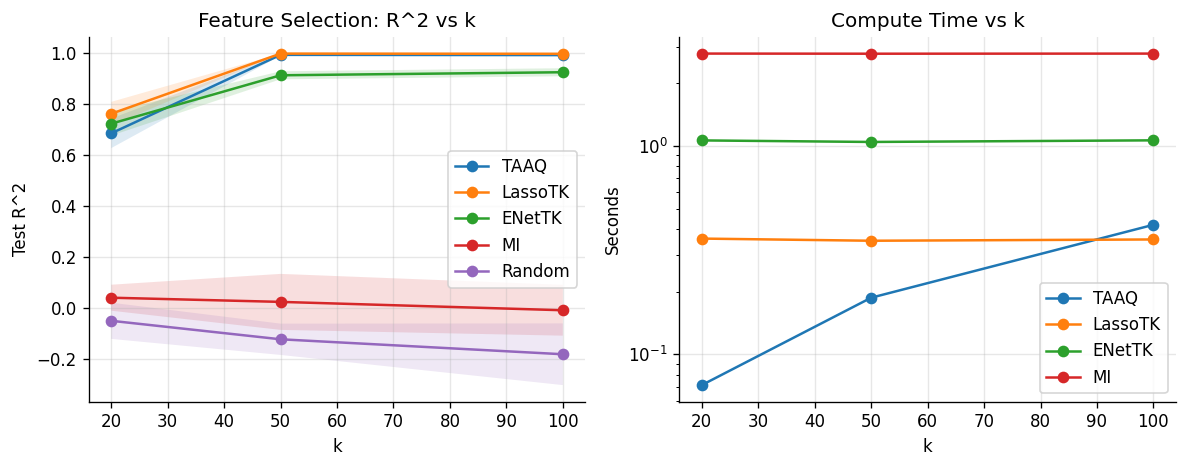

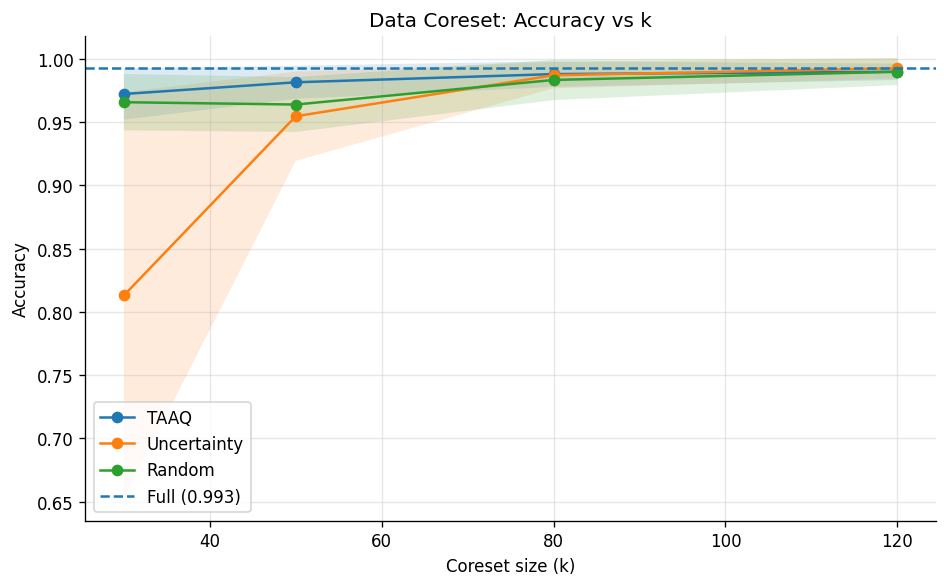

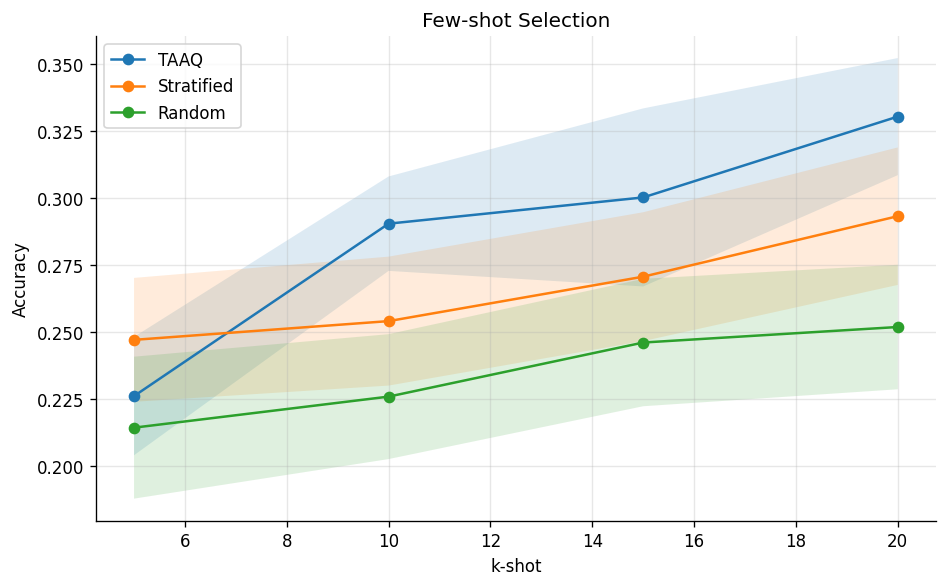

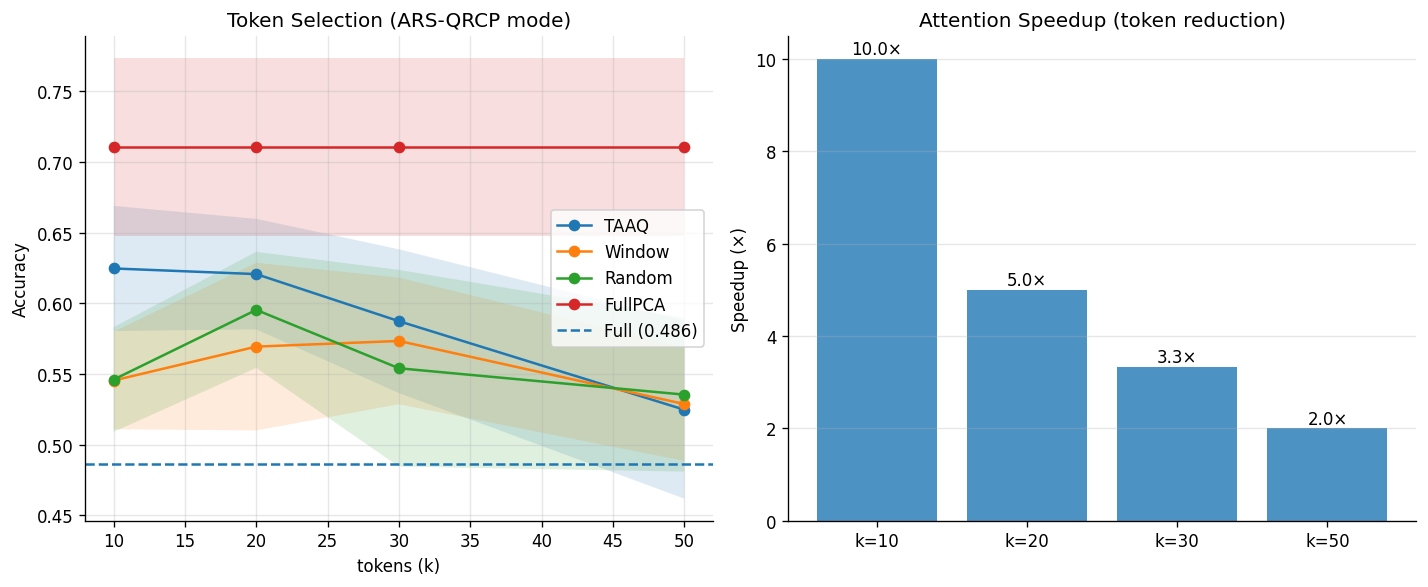

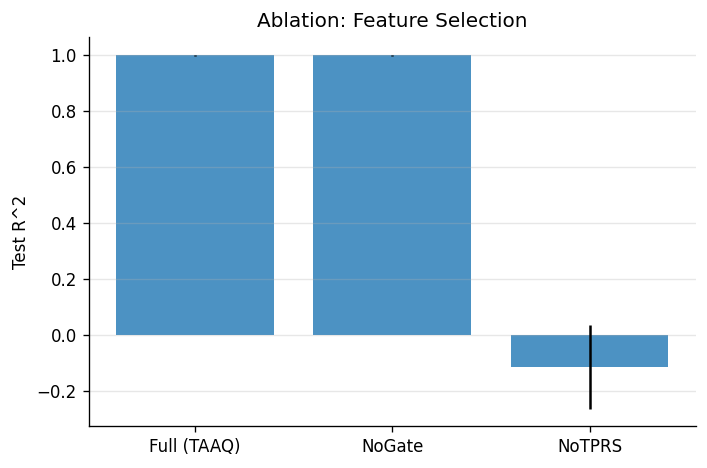

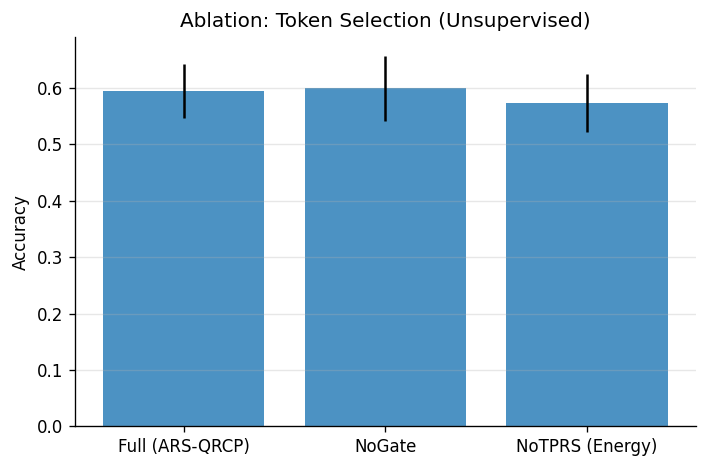

In [87]:
if __name__ == "__main__":
    _ = run_all()